In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# import packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE as TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import interpn

In [2]:
plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 10})

In [3]:
df_train = pd.read_csv('orders_split/orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('orders_split/orders0206_train.csv', sep='|', parse_dates=['time'])
df_info = pd.read_csv('infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('items.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

## insights
- which dates do they normally have promotions?
- which types of products on which days?

In [4]:
promotion_iterate = []
promo_dates = []
name_list = []
for i, promotion in enumerate(df_info["promotion"]):
    promotion = str(promotion)
    promotion_iterate.append(promotion)
#save IDs with >= 1 promotion
i_iterate = []
for i, promotion in enumerate(promotion_iterate):
     if promotion != "nan":  
        i_iterate.append(i)
# print out days with promotions
for pro in range(len(i_iterate)):
    promo_dates.append(promotion_iterate[i_iterate[pro]])

#for i in range(len(name_list)):
 #   promo_dates.groupby(name_list[i]).sum()

In [5]:
dateslist = []
for dates in promo_dates:
    dateslist.append(dates.split(','))


In [6]:
dates = []
for i in range(len(dateslist)):
    if len(dateslist[i]) == 1:
        dates.append(dateslist[i])
    else:
        for j in range(len(dateslist[i])):
            dates.append([dateslist[i][j]])


In [7]:
len(dateslist) # 1843 promotion items
len(dates) # 2066 promotion dates # some items promote several dates         

2066

In [8]:
from collections import Counter
dates_counter = []
flattened  = [val for sublist in dates for val in sublist]
dates_counter.append(Counter(flattened))

(array([241., 192., 147., 419., 179., 141., 267., 164., 109., 207.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

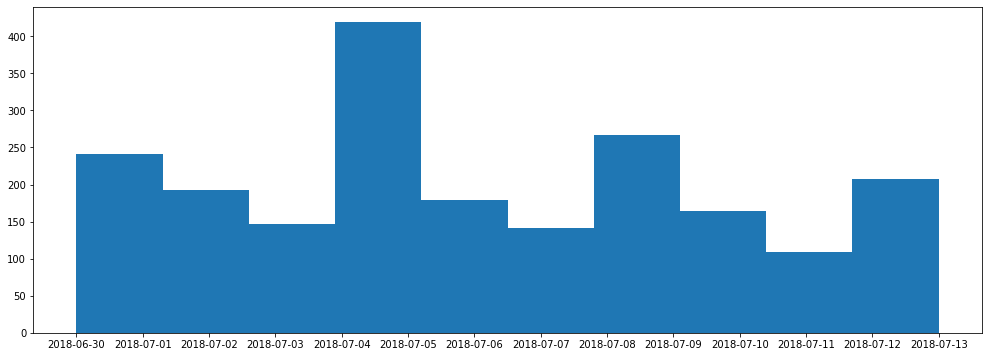

In [9]:
plt.hist(sorted(flattened))

### Find most popular items


In [10]:
item_sold_list = df_train["itemID"].values.tolist()

In [11]:
from collections import Counter 
item_sold_count = Counter(item_sold_list) 

In [12]:
#### category1   5.00 category2   21.00 category3   4.00 is the most sold category

In [13]:
item_sold_count.most_common(10)

[(5117, 8027),
 (5035, 7949),
 (5122, 5430),
 (5139, 5173),
 (7789, 5020),
 (4208, 4984),
 (4322, 4944),
 (8371, 4523),
 (5029, 3870),
 (8006, 3761)]

In [14]:
print(df_items.loc[ 5117 , : ])
print(df_items.loc[ 5035 , : ])# it has promo in July
print(df_items.loc[ 5122 , : ])
print(df_items.loc[ 5139 , : ])

brand                     90.00
manufacturer              80.00
customerRating             3.26
category1                  5.00
category2                 21.00
category3                  4.00
recommendedRetailPrice    26.68
Name: 5117, dtype: float64
brand                     90.00
manufacturer              80.00
customerRating             3.41
category1                  5.00
category2                 21.00
category3                  4.00
recommendedRetailPrice    17.49
Name: 5035, dtype: float64
brand                     92.00
manufacturer              80.00
customerRating             4.36
category1                  5.00
category2                 21.00
category3                  4.00
recommendedRetailPrice     9.04
Name: 5122, dtype: float64
brand                     90.00
manufacturer              80.00
customerRating             4.11
category1                  5.00
category2                 21.00
category3                  4.00
recommendedRetailPrice    17.38
Name: 5139, dtype: floa

### check possible bundles
- If the price get higher & sales got more -- > bundles
### What's normally sold together?
- If same time and transactID --> look up "itemID" and save "itemID" into a list to new column

In [5]:
df_train = pd.read_csv('orders_split/orders0206_train.csv', sep='|', parse_dates=['time'])

In [8]:
df_train['transactID'] = df_train['transactID'].astype(str)
df_train['time'] = df_train['time'].astype(str)

### use 'transactID','time' as new  "cartID"

In [9]:
df_train = df_train.assign(id=(df_train['time'] +  df_train['transactID']).astype('category').cat.codes)
# set new ID
df_train = df_train.drop(columns=['transactID','time'])
#df_train = df_train.rename(columns={"id": "same_cart"})
df_train = df_train[['id', 'itemID','order','salesPrice']]
df_train.head()

,id,itemID,order,salesPrice
0,0,450,1,17.42
1,0,83,1,5.19
2,1,7851,2,20.47
3,2,450,1,17.42
4,2,83,1,5.19


In [18]:
from itertools import combinations
from collections import defaultdict
import time
x = df_train['id'][0:200]  # invoice number
y = df_train['itemID'][0:200]  # item
start = time.time()
z = defaultdict(set)
for i, j in zip(x, y):
    z[i].add(j)
#print(z)
for i in range(len(z)):
    if len(z[i]) <= 1:
        del z[i] 
# delete only 1 
print(z)
d = defaultdict(int)
for i in range(2, len(z)):
    # 2 2 sets
    combs = combinations(set(y), i)
    for comb in combs:
        for k, v in z.items():
            if set(comb).issubset(set(v)):
                d[tuple(comb)] += 1
print('Total time: ' + str((time.time() - start)) + ' secs')
save_list = list(reversed(sorted([[v, k] for k, v in d.items()])))
## print top 10
#run 100 times use 2.8508410453796387 secs, the time is a^2 more :(
save_list[0:10]

defaultdict(<class 'set'>, {0: {450, 83}, 2: {450, 83}, 4: {450, 295, 297, 109, 19, 83}, 6: {450, 295, 297, 109, 83, 19}, 8: {8192, 7975}, 60: {6574, 6575}, 63: {8075, 8107}, 107: {520, 222}, 125: {520, 222}})
Total time: 59.81690812110901 secs


[[4, (450, 83)],
 [2, (520, 222)],
 [2, (450, 109)],
 [2, (450, 83, 109)],
 [2, (297, 450, 109)],
 [2, (297, 450, 83, 109)],
 [2, (297, 450, 83)],
 [2, (297, 450)],
 [2, (297, 109)],
 [2, (297, 83, 109)]]

df_train

In [19]:
df_items.head()

,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
itemID,,,,,,,
1,0,1,4.38,1,1,1,8.84
2,0,2,3.00,1,2,1,16.92
3,0,3,5.00,1,3,1,15.89
4,0,2,4.44,1,2,1,40.17
5,0,2,2.33,1,1,1,17.04


In [20]:
df_train_joined.head()

,time,transactID,itemID,order,salesPrice,simulationPrice,promotion,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42,17.42,NaN,0,7,0.00,1,2,1,27.00
1,2018-01-01 00:01:56,2278968,83,1,5.19,5.19,NaN,0,4,0.00,1,1,1,12.89
2,2018-01-01 00:07:11,2255797,7851,2,20.47,20.47,NaN,0,202,4.75,4,39,7,11.75
3,2018-01-01 00:09:24,2278968,450,1,17.42,17.42,NaN,0,7,0.00,1,2,1,27.00
4,2018-01-01 00:09:24,2278968,83,1,5.19,5.19,NaN,0,4,0.00,1,1,1,12.89


### Association Analysis

In [21]:
#!pip install mlxtend

In [10]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [11]:
df_train[0:10]

,id,itemID,order,salesPrice
0,0,450,1,17.42
1,0,83,1,5.19
2,1,7851,2,20.47
3,2,450,1,17.42
4,2,83,1,5.19
5,3,9375,1,31.02
6,4,450,1,17.42
7,4,83,1,5.19
8,4,19,1,77.64
9,4,297,1,43.53


In [12]:
df_train.dropna(axis=0, subset=['id'], inplace=True)

In [13]:
df_train_2 = df_train[df_train.groupby(['id'])['itemID'].transform('nunique') > 1]

In [14]:
df_train_2[0:10]

,id,itemID,order,salesPrice
0,0,450,1,17.42
1,0,83,1,5.19
3,2,450,1,17.42
4,2,83,1,5.19
6,4,450,1,17.42
7,4,83,1,5.19
8,4,19,1,77.64
9,4,297,1,43.53
10,4,295,1,37.79
11,4,109,1,5.80


In [15]:
basket = (df_train_2
          .groupby(['id', 'itemID'])['order']
          .sum().unstack().reset_index().fillna(0)
          .set_index('id'))

In [16]:
## make it one hot encoding look
basket.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
basket2 = (df_train_2[0:100]
          .groupby(['id', 'itemID'])['order']
          .sum().unstack().reset_index().fillna(0)
          .set_index('id'))

In [16]:
basket2.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
## test on small data of basket2
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets2 = basket2.applymap(encode_units)

In [17]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
#basket_sets 

In [18]:
basket_sets.head()


itemID,1,2,3,4,5,6,8,10,11,12,...,10260,10287,10296,10300,10301,10353,10355,10395,10411,10431
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
frequent_itemsets = apriori(basket_sets2, min_support=0.04, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.045455,(19)
1,0.090909,(83)
2,0.045455,(109)
3,0.113636,(202)
4,0.477273,(222)
5,0.045455,(295)
6,0.045455,(297)
7,0.090909,(450)
8,0.045455,(520)
9,0.045455,(4301)


In [35]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(83),(19),0.090909,0.045455,0.045455,0.500000,11.000000,0.041322,1.909091
1,(19),(83),0.045455,0.090909,0.045455,1.000000,11.000000,0.041322,inf
2,(19),(109),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
3,(109),(19),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
4,(19),(295),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
5,(295),(19),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
6,(297),(19),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
7,(19),(297),0.045455,0.045455,0.045455,1.000000,22.000000,0.043388,inf
8,(450),(19),0.090909,0.045455,0.045455,0.500000,11.000000,0.041322,1.909091
9,(19),(450),0.045455,0.090909,0.045455,1.000000,11.000000,0.041322,inf


In [19]:
frequent_itemsets = apriori(basket_sets, min_support=0.00124, use_colnames=True)
print(frequent_itemsets.head())
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules.head())

    support itemsets
0  0.001484      (3)
1  0.001388     (27)
2  0.001316     (83)
3  0.001867    (193)
4  0.001891    (251)
  antecedents consequents  antecedent support  consequent support   support  \
0       (456)       (251)            0.003375            0.001891  0.001412   
1       (251)       (456)            0.001891            0.003375  0.001412   
2       (569)       (381)            0.002800            0.001867  0.001484   
3       (381)       (569)            0.001867            0.002800  0.001484   
4      (2350)      (2582)            0.001915            0.015581  0.001508   

   confidence        lift  leverage  conviction  
0    0.418440  221.306940  0.001406    1.716261  
1    0.746835  221.306940  0.001406    3.936670  
2    0.529915  283.857550  0.001479    2.123301  
3    0.794872  283.857550  0.001479    4.861349  
4    0.787500   50.542742  0.001478    4.632561  


In [20]:
# 0.00123 is fine with 413 frequent items
frequent_itemsets


,support,itemsets
0,0.001484,(3)
1,0.001388,(27)
2,0.001316,(83)
3,0.001867,(193)
4,0.001891,(251)
5,0.001556,(328)
6,0.001867,(381)
7,0.001316,(429)
8,0.003375,(456)
9,0.001412,(567)


In [21]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(456),(251),0.003375,0.001891,0.001412,0.418440,221.306940,0.001406,1.716261
1,(251),(456),0.001891,0.003375,0.001412,0.746835,221.306940,0.001406,3.936670
2,(569),(381),0.002800,0.001867,0.001484,0.529915,283.857550,0.001479,2.123301
3,(381),(569),0.001867,0.002800,0.001484,0.794872,283.857550,0.001479,4.861349
4,(2350),(2582),0.001915,0.015581,0.001508,0.787500,50.542742,0.001478,4.632561
5,(2582),(2350),0.015581,0.001915,0.001508,0.096774,50.542742,0.001478,1.105023
6,(4260),(4485),0.004212,0.013929,0.002298,0.545455,39.158388,0.002239,2.169355
7,(4485),(4260),0.013929,0.004212,0.002298,0.164948,39.158388,0.002239,1.192486
8,(4485),(4261),0.013929,0.003997,0.001723,0.123711,30.951540,0.001668,1.136615
9,(4261),(4485),0.003997,0.013929,0.001723,0.431138,30.951540,0.001668,1.733408


In [ ]:
## 0.001228 fail
frequent_itemsets = apriori(basket_sets, min_support=0.001229, use_colnames=True)
print(frequent_itemsets.head())
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)